In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df = pd.read_csv('data/bug-severity-cleaned.csv')
df.head()

,ticket_id,submitted_at,product_area,customer_type,priority,reporter_experience,reproduction_steps,num_attachments,description_length,affected_users_count,prev_similar_tickets,module_version,ticket_type,auto_tag_count,sla_breached,assigned_team,severity,resolved_at,resolution_time
0,TCKT-100000,2023-09-29 13:35:00,Auth,Internal,Medium,Senior,1,1,574.0,13.0,0.0,5.2.11,Bug,5,0,Qa,Medium,2023-09-30 19:35:00,30.0
1,TCKT-100001,2025-03-05 06:23:00,Devops,Internal,High,Junior,1,0,299.0,16.0,2.0,4.2.4,Question,3,1,Dev,Medium,2025-03-06 16:23:00,34.0
2,TCKT-100002,2023-07-25 18:40:00,Ml,Smb,Low,Junior,0,2,526.0,13.0,0.0,3.2.11,Bug,1,0,Qa,Low,2023-07-27 02:40:00,32.0
3,TCKT-100003,2023-10-18 22:03:00,Auth,Free-Tier,Low,Mid,1,2,734.0,7.0,0.0,4.8.4,Bug,2,0,Qa,Low,2023-10-20 03:03:00,29.0
4,TCKT-100004,2025-06-27 00:35:00,Backend,Enterprise,Medium,Mid,1,1,374.0,7.0,3.0,2.9.15,Bug,3,0,Security,Medium,2025-06-27 07:35:00,7.0


In [35]:
print("Fature Engineering - Outlier Handling")
print("-------------------------------------")
print("\n Handling affected_users_count (Critical Outlies)")

# Before transformation
print(f"Original - Min: {df['affected_users_count'].min()}, "
      f"Max: {df['affected_users_count'].max()}, "
      f"Median: {df['affected_users_count'].median()}")

# Log Transformation
df['affected_users_count_log'] = np.log1p(df['affected_users_count'])

# After transformation
print(f"Log transformed - Min: {df['affected_users_count_log'].min():.2f}, "
      f"Max: {df['affected_users_count_log'].max():.2f}, "
      f"Median: {df['affected_users_count_log'].median():.2f}")

# Impact indicators
df['is_widespread'] = (df['affected_users_count'] > 50).astype(int)
df['is_critical_impact'] = (df['affected_users_count'] > 500).astype(int)
df['affects_users'] = (df['affected_users_count'] > 0).astype(int)

# Impact level categories
df['impact_level'] = pd.cut(
    df['affected_users_count'],
    bins=[-1, 0, 5, 20, 100, 10000],
    labels=['none', 'individual', 'small_team', 'department', 'enterprise']
)

print(" Created: affected_users_count_log, impact_level, impact flags")

Fature Engineering - Outlier Handling
-------------------------------------

 Handling affected_users_count (Critical Outlies)
Original - Min: 1.0, Max: 4932.0, Median: 10.0
Log transformed - Min: 0.69, Max: 8.50, Median: 2.40
 Created: affected_users_count_log, impact_level, impact flags


In [36]:
print("\n Handling number of attachements ")

# Log transformation
df['num_attachments_log'] = np.log1p(df['num_attachments'])

# Indicators
df['has_attachments'] = (df['num_attachments'] > 0).astype(int)
df['many_attachments'] = (df['num_attachments'] > 5).astype(int)

# Categories
df['attachment_category'] = pd.cut(
    df['num_attachments'],
    bins=[-1, 0, 2, 5, 100],
    labels=['none', 'few', 'moderate', 'many']
)

print("Created: recurrence_category, recurrence flags")


 Handling number of attachements 
Created: recurrence_category, recurrence flags


In [37]:
print("\n Handling auto tag count ")
# Keep original, simple binning
df['is_multi_category'] = (df['auto_tag_count'] > 3).astype(int)

df['tag_complexity'] = pd.cut(
    df['auto_tag_count'],
    bins=[-1, 1, 3, 5, 100],
    labels=['minimal', 'standard', 'complex', 'very_complex']
)

print("Created: tag_complexity, multi-category flag")


 Handling auto tag count 
Created: tag_complexity, multi-category flag


In [38]:
# Create outlier flags (all features)
numerical_columns = ['affected_users_count', 'num_attachments', 'auto_tag_count','description_length', 'prev_similar_tickets']

for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Standard outlier thresholds
    df[f'{col}_is_outlier'] = (
        (df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)
    ).astype(int)

    # Extreme outlier (3*IQR)
    df[f'{col}_is_extreme'] = (
        (df[col] < Q1 - 3*IQR) | (df[col] > Q3 + 3*IQR)
    ).astype(int)
    
    outlier_count = df[f'{col}_is_outlier'].sum()
    print(f"  {col}: {outlier_count} outliers ({outlier_count/len(df)*100:.1f}%)")

  affected_users_count: 83 outliers (1.7%)
  num_attachments: 63 outliers (1.3%)
  auto_tag_count: 27 outliers (0.5%)
  description_length: 42 outliers (0.8%)
  prev_similar_tickets: 1 outliers (0.0%)


In [39]:
# Create interaction feature
print("\n. Creating interaction features")

# High-impact complexity score
df['severity_score'] = (
    df['affected_users_count_log'] * 0.4 +
    df['num_attachments_log'] * 0.2 +
    df['description_length'] / 100 * 0.2 +
    df['prev_similar_tickets'] * 0.2
)

# Critical incident flag
df['is_critical_incident'] = (
    (df['affected_users_count'] > 100) |
    (df['num_attachments'] > 10) |
    ((df['affected_users_count'] > 20) & (df['prev_similar_tickets'] > 1))
).astype(int)

# Documentation quality
df['documentation_score'] = (
    df['has_attachments'] * 0.4 +
    (df['description_length'] > 400).astype(int) * 0.4 +
    df['reproduction_steps'] * 0.2
)

# Impact per documentation ratio
df['impact_per_doc'] = (
    df['affected_users_count_log'] / 
    (df['num_attachments_log'] + 1)
)

print("Created: severity_score, critical_incident_flag, documentation_score")



. Creating interaction features
Created: severity_score, critical_incident_flag, documentation_score



 Visualizing transformation effects 


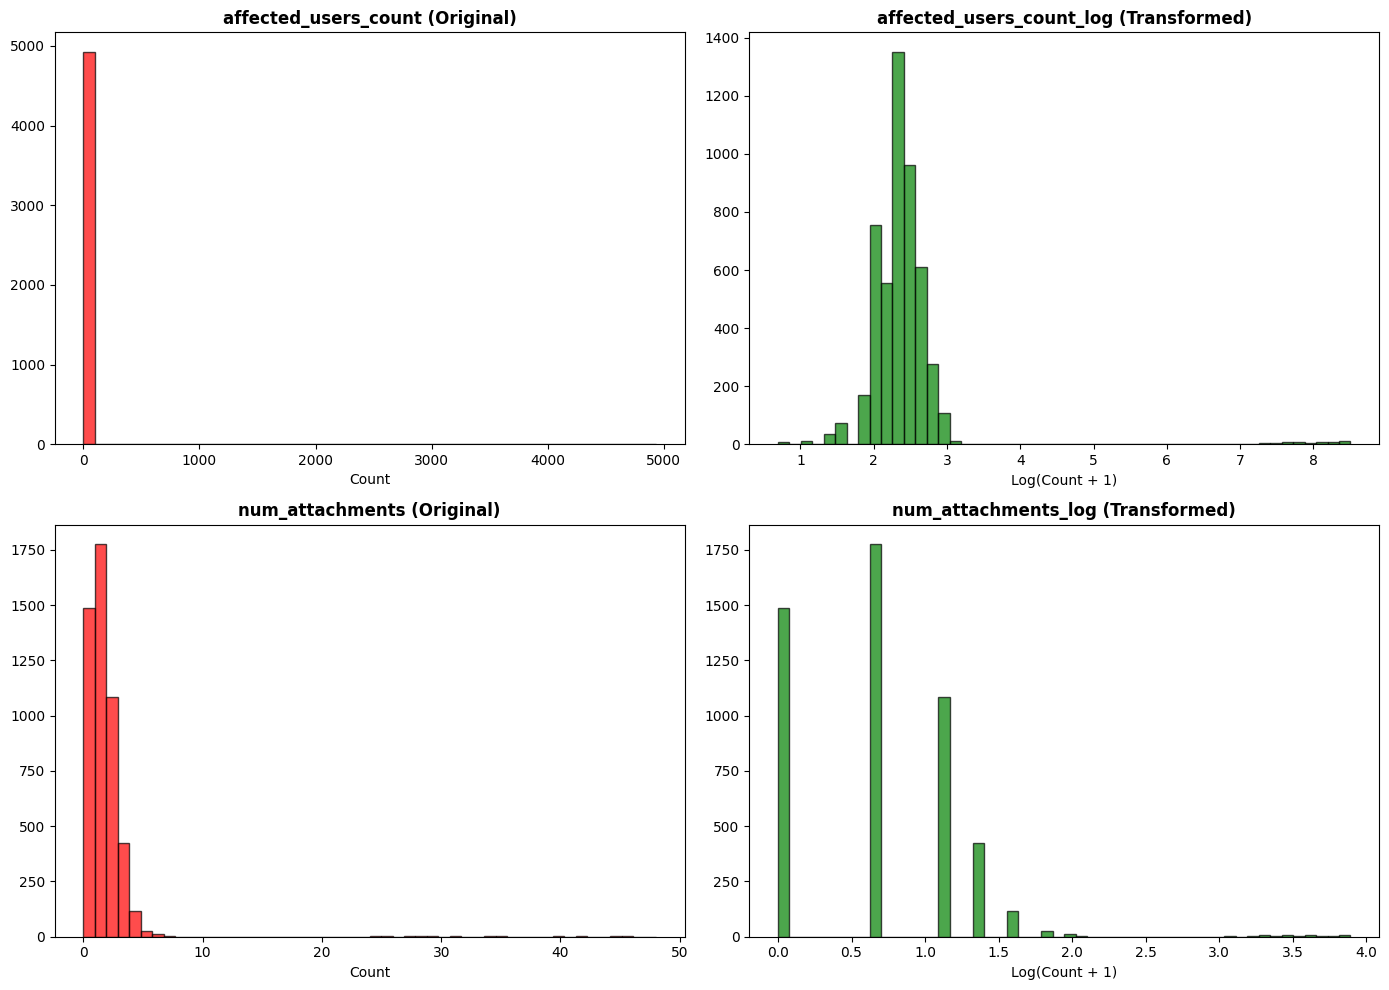

Saved visualization: transformation_comparison.png


In [40]:
# Visualize transformation effects
print("\n Visualizing transformation effects ")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# affected_users_count: Before vs After
axes[0, 0].hist(df['affected_users_count'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('affected_users_count (Original)', fontweight='bold')
axes[0, 0].set_xlabel('Count')

axes[0, 1].hist(df['affected_users_count_log'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('affected_users_count_log (Transformed)', fontweight='bold')
axes[0, 1].set_xlabel('Log(Count + 1)')

# num_attachments: Before vs After
axes[1, 0].hist(df['num_attachments'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('num_attachments (Original)', fontweight='bold')
axes[1, 0].set_xlabel('Count')

axes[1, 1].hist(df['num_attachments_log'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('num_attachments_log (Transformed)', fontweight='bold')
axes[1, 1].set_xlabel('Log(Count + 1)')


plt.tight_layout()
plt.savefig('transformation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved visualization: transformation_comparison.png")

In [41]:
print("\n Feature engineering Summary.")

print(f"\nOriginal features: 5")
print(f"Engineered features created: {len(df.columns) - len(numerical_columns)}")
print(f"Total features now: {len(df.columns)}")

print("\nKey transformations:")
print("Log transforms: 2 (affected_users_count, num_attachments)")
print("Categorical bins: 5 features")
print("Outlier indicators: 10 features (5 normal + 5 extreme)")
print("Interaction features: 4 features")
print("Binary flags: 10+ features")


 Feature engineering Summary.

Original features: 5
Engineered features created: 39
Total features now: 44

Key transformations:
Log transforms: 2 (affected_users_count, num_attachments)
Categorical bins: 5 features
Outlier indicators: 10 features (5 normal + 5 extreme)
Interaction features: 4 features
Binary flags: 10+ features


In [42]:
df.to_csv('data/feature_engineered_data.csv', index=False)
print(f"\n Saved: feature_engineered_data.csv")
print(f"  Shape: {df.shape}")


 Saved: feature_engineered_data.csv
  Shape: (4975, 44)
